# Predicting Patient Survival with ML
TASKS:

1. Implement logistic regression, decision tree, random forest to predict patient survival

2. Interpret and compare models

## Data Preparation

In [1]:
import os
import random

from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sqlite3 import connect

from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import f1_score, classification_report

In [2]:
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

### Load and Clean Data

In [3]:
icu_df = pd.read_csv('icu.csv', index_col=0, usecols=['ID',	'Age', 'Sex', 'Infection', 'SysBP', 'Pulse', 'Emergency', 'Survive'])
icu_df

,Survive,Age,Sex,Infection,SysBP,Pulse,Emergency
ID,,,,,,,
4,0,87,1,1,80,96,1
8,1,27,1,1,142,88,1
12,1,59,0,0,112,80,1
14,1,77,0,0,100,70,0
27,0,76,1,1,128,90,1
...,...,...,...,...,...,...,...
921,0,50,1,0,256,64,1
923,1,20,0,0,104,83,1
924,1,73,1,0,162,100,1


In [4]:
icu_df.dropna()

,Survive,Age,Sex,Infection,SysBP,Pulse,Emergency
ID,,,,,,,
4,0,87,1,1,80,96,1
8,1,27,1,1,142,88,1
12,1,59,0,0,112,80,1
14,1,77,0,0,100,70,0
27,0,76,1,1,128,90,1
...,...,...,...,...,...,...,...
921,0,50,1,0,256,64,1
923,1,20,0,0,104,83,1
924,1,73,1,0,162,100,1


In [5]:
icu_df['Survive'].value_counts()

1    160
0     40
Name: Survive, dtype: int64

### Save Data to SQLite Database

In [6]:
conn = connect('database.db')
icu_df.to_sql('icu', conn, if_exists='replace')

### Visualize Data

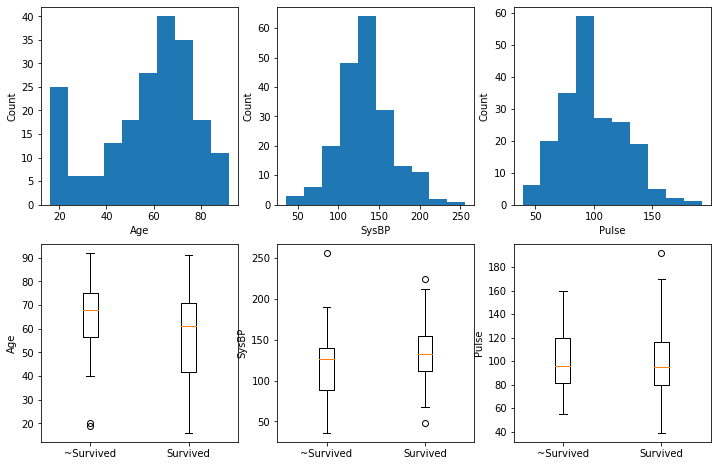

In [7]:
# Plot histograms for continous variables
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
features = ['Age', 'SysBP', 'Pulse']

for (i, feature) in enumerate(features):
    fetched_data = pd.read_sql(f"SELECT {feature} FROM icu", conn).squeeze()
    axs[0, i].hist(fetched_data)
    axs[0, i].set_xlabel(feature)
    axs[0, i].set_ylabel("Count")

for (i, feature) in enumerate(features):
    fetched_not_survived_data = pd.read_sql(f"SELECT {feature} FROM icu WHERE Survive=0", conn).squeeze()
    fetched_survived_data = pd.read_sql(f"SELECT {feature} FROM icu WHERE Survive=1", conn).squeeze()
    axs[1, i].boxplot([fetched_not_survived_data, fetched_survived_data])
    axs[1, i].set_xticks([1,2], labels=['~Survived', 'Survived'])
    axs[1, i].set_ylabel(feature)

plt.show() 

In [8]:
features = ['Sex', 'Infection', 'Emergency']
survive_col = pd.read_sql(f"SELECT Survive FROM icu", conn).squeeze()

for (i, feature) in enumerate(features):
    fetched_data = pd.read_sql(f"SELECT {feature} FROM icu", conn).squeeze()
    print(pd.crosstab(survive_col, fetched_data))


Sex        0   1
Survive         
0         24  16
1        100  60
Infection    0   1
Survive           
0           16  24
1          100  60
Emergency   0    1
Survive           
0           2   38
1          51  109


### Preprocess Data

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [10]:
# Scale age to between 0 and 1 
scaler = MinMaxScaler()
icu_df[['Age']] = scaler.fit_transform(icu_df[['Age']])

# Standardize SysBP and Pulse due to gaussian distribution
scaler = StandardScaler()
icu_df[['SysBP', 'Pulse']] = scaler.fit_transform(icu_df[['SysBP', 'Pulse']])
icu_df

,Survive,Age,Sex,Infection,SysBP,Pulse,Emergency
ID,,,,,,,
4,0,0.934211,1,1,-1.590527,-0.109295,1
8,1,0.144737,1,1,0.295714,-0.408221,1
12,1,0.565789,0,0,-0.616983,-0.707147,1
14,1,0.802632,0,0,-0.982062,-1.080805,0
27,0,0.789474,1,1,-0.130211,-0.333489,1
...,...,...,...,...,...,...,...
921,0,0.447368,1,0,3.763963,-1.305000,1
923,1,0.052632,0,0,-0.860369,-0.595050,1
924,1,0.750000,1,0,0.904179,0.040168,1


#### Split data into train and test

In [11]:
X, y = icu_df.iloc[:, 1:], icu_df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## Implement ML Models

In [12]:
kfold = KFold(n_splits=5, random_state=SEED, shuffle=True)

### Logistic Regression

#### Find Best Hyperaparameters

In [13]:
C = np.arange(1,10)
hyperparameters = dict(C=C)
lr_model = LogisticRegression(random_state=SEED)

grid_search = GridSearchCV(lr_model, hyperparameters, cv=5)
fine_tuned_model = grid_search.fit(X_train, y_train)
print(f"Best C: {fine_tuned_model.best_estimator_.get_params()['C']}")


Best C: 1


#### Fit Model

In [14]:
best_c = fine_tuned_model.best_estimator_.get_params()['C']
lr_clf = LogisticRegression(random_state=SEED, C=best_c)

In [15]:
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1, random_state=42)

### Decision Tree

#### Find Best Hyperaparameters

In [16]:
max_leaf_nodes = np.arange(2, 100, 2)
min_samples_split = np.arange(2, 8, 2)
criterion = ['gini', 'entropy']
class_weight = ["balanced", None]
hyperparameters = dict(max_leaf_nodes=max_leaf_nodes, min_samples_split=min_samples_split, criterion=criterion, class_weight=class_weight)
decision_tree = DecisionTreeClassifier(random_state=SEED)

grid_search = GridSearchCV(decision_tree, hyperparameters, cv=5)
fine_tuned_model = grid_search.fit(X_train, y_train)
print(f"Best maximum leaf nodes: {fine_tuned_model.best_estimator_.get_params()['max_leaf_nodes']}")
print(f"Best minimum samples split: {fine_tuned_model.best_estimator_.get_params()['min_samples_split']}")
print(f"Best criterion: {fine_tuned_model.best_estimator_.get_params()['criterion']}")
print(f"Best class_weight: {fine_tuned_model.best_estimator_.get_params()['class_weight']}")



Best maximum leaf nodes: 2
Best minimum samples split: 2
Best criterion: gini
Best class_weight: None


#### Fit and Plot Tree

In [17]:
min_samples_split = fine_tuned_model.best_estimator_.get_params()['min_samples_split']
max_leaf_nodes = fine_tuned_model.best_estimator_.get_params()['max_leaf_nodes']
criterion = fine_tuned_model.best_estimator_.get_params()['criterion']
class_weight = fine_tuned_model.best_estimator_.get_params()['class_weight']
decision_tree = DecisionTreeClassifier(random_state=SEED,
                                       criterion=criterion,
                                       min_samples_split=min_samples_split,
                                       max_leaf_nodes=max_leaf_nodes,
                                      class_weight=class_weight)


In [18]:
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=2, random_state=42)

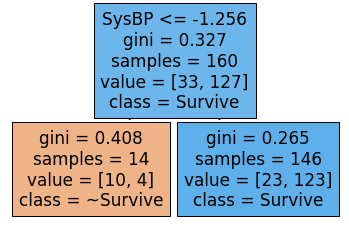

In [19]:
plot_tree(decision_tree,
          feature_names=['Age', 'Sex', 'Infection', 'SysBP', 'Pulse', 'Emergency'],  
            class_names=['~Survive', 'Survive'],
            filled = True)
plt.show()

## Random Tree

#### Find Best Hyperparameters

In [20]:
n_estimators = np.arange(10, 100, 10)
max_leaf_nodes = np.arange(2, 18, 2)
min_samples_split = np.arange(2, 8, 2)
criterion = ['gini', 'entropy']
class_weight = ['balanced', None]

hyperparameters = dict(n_estimators=n_estimators,
                       max_leaf_nodes=max_leaf_nodes,
                       min_samples_split=min_samples_split,
                       criterion=criterion,
                        class_weight=class_weight)
random_forest_clf = RandomForestClassifier(random_state=SEED)

grid_search = GridSearchCV(random_forest_clf, hyperparameters, cv=5)
fine_tuned_model = grid_search.fit(X_train, y_train)
print(f"Best no. of estimators: {fine_tuned_model.best_estimator_.get_params()['n_estimators']}")
print(f"Best maximum leaf nodes: {fine_tuned_model.best_estimator_.get_params()['max_leaf_nodes']}")
print(f"Best minimum samples split: {fine_tuned_model.best_estimator_.get_params()['min_samples_split']}")
print(f"Best criterion: {fine_tuned_model.best_estimator_.get_params()['criterion']}")
print(f"Best class weight: {fine_tuned_model.best_estimator_.get_params()['class_weight']}")

Best no. of estimators: 30
Best maximum leaf nodes: 8
Best minimum samples split: 2
Best criterion: gini
Best class weight: None


#### Fit and Plot Tree

In [21]:
n_estimators = fine_tuned_model.best_estimator_.get_params()['n_estimators']
max_leaf_nodes = fine_tuned_model.best_estimator_.get_params()['max_leaf_nodes']
min_samples_split = fine_tuned_model.best_estimator_.get_params()['min_samples_split']
criterion = fine_tuned_model.best_estimator_.get_params()['criterion']
class_weight = fine_tuned_model.best_estimator_.get_params()['class_weight']
random_forest_clf = RandomForestClassifier(random_state=SEED,
                                    n_estimators=n_estimators,
                                    criterion=criterion,
                                    min_samples_split=min_samples_split,
                                    max_leaf_nodes=max_leaf_nodes,
                                    class_weight = None)

In [22]:
random_forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=8, n_estimators=30, random_state=42)

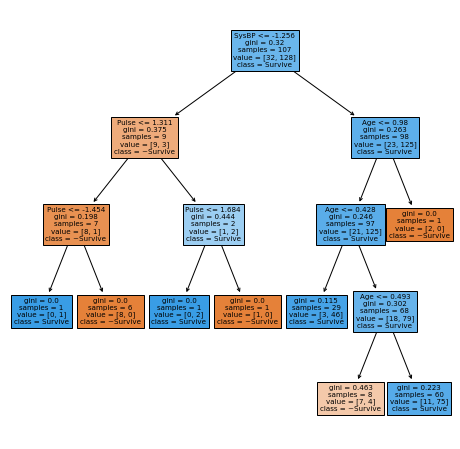

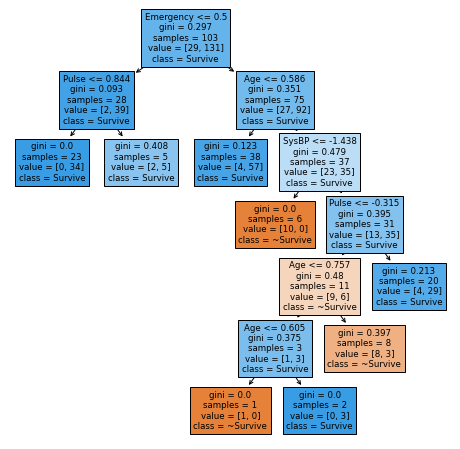

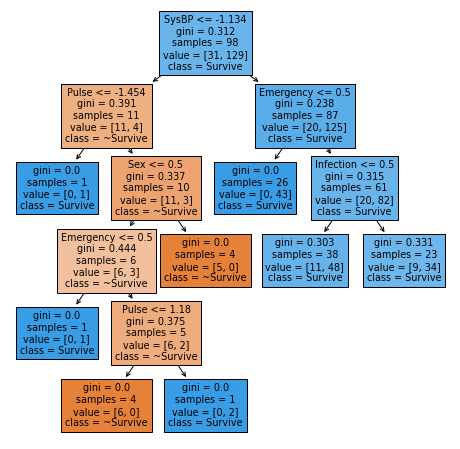

In [23]:
for (i, estimator) in enumerate(random_forest_clf.estimators_[:3]):
    plt.figure(figsize=(8,8))
    plot_tree(estimator,
              feature_names=['Age', 'Sex', 'Infection', 'SysBP', 'Pulse', 'Emergency'],  
                class_names=['~Survive', 'Survive'],
                filled = True)
plt.show()

## Evaluation Metrics
F1 scores were used in addition to accuracy to evaluate the machine learning models. F1 score serves as a more useful metric in this case due to the uneven class distribution.

More importantly, F1 score penalises for false negatives. This prevents the model from predicting that a patient survives when they are not likely to, so that help and resources could be provided timely. At the same time, it would be helpful to accurately predict that a patient would actually survive for resources to be diverted to other needy patients.

## Test Results

### Logistic Regression

In [24]:
y_test_pred = lr_clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.85      1.00      0.92        33

    accuracy                           0.85        40
   macro avg       0.92      0.57      0.58        40
weighted avg       0.87      0.85      0.80        40



### Decision Tree

In [25]:
y_test_pred = decision_tree.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.50      0.29      0.36         7
           1       0.86      0.94      0.90        33

    accuracy                           0.82        40
   macro avg       0.68      0.61      0.63        40
weighted avg       0.80      0.82      0.80        40



### Random Forest

In [26]:
y_test_pred = random_forest_clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.33      0.14      0.20         7
           1       0.84      0.94      0.89        33

    accuracy                           0.80        40
   macro avg       0.59      0.54      0.54        40
weighted avg       0.75      0.80      0.77        40



## Interpretation and Comparison of ML Models

#### Overall Results
Despite all models achieving an accuracy of 80% and above, the macro-average scores obtained are significantly lower due to the low precision and recall when classifying patients that will not survive.

The lower recall for predicting non-survival is likely to be due to insufficient training samples for the minority class. Attempts to resolve this by over-sampling (using Synthetic Minority Oversampling Technique) resulted in significantly lower accuracy and was thus omitted in this notebook.

#### Comparing Logistic Regression and Decision Tree
While the accuracy of the logistic regression model was 3.5% higher than that of the decision tree, it resulted in a 7.93% lower macro-average accuracy.

The logistic regression model showed a greater bias towards classifying a patient to be able to survive. This is likely because linear classifiers do not work as well on higher-dimensional data. In contrast, the decision tree can classify the data non-linearly. In this case, it made use of a single feature, sysBP, to classify each patient, resulting in a higher macro-averaged score.

#### Comparing Decision Tree and Random Forest
The random forest classifier performed worse than the decision tree on all metrics. This suggests that the random forest is a less effective classifier as compared to the decision tree.

While random forest classifiers are generally more robust than a single decision tree classifier and has less chance of overfitting, the lack of training data had likely caused individual tress in the random forest to make less accurate decisions when averaged, as compared to the decision tree.

#### Conclusion


The decision tree was the most useful model in this case, attaining the highest macro-averaged f1 score of 0.61. With more training data, however, random forest could prove to perform better.